<a href="https://colab.research.google.com/github/rio0103/Mini-Project-/blob/main/FYP_code_(cuboid).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the data

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FYP_Data_Cuboid(training)(constant).xlsx to FYP_Data_Cuboid(training)(constant).xlsx


In [ ]:
import io
import pandas as pd

data = pd.read_excel(io.BytesIO(uploaded['FYP_Data_Cuboid(training)(constant).xlsx']))
data.head()

,Layer,Volume (mm^3),Layer thickness (mm),Area (mm^2),Previous DMX (mm),DMX (mm)
0,1,50,0.5,100,0.000000,0.042274
1,2,50,0.5,100,0.042274,0.069911
2,3,50,0.5,100,0.069911,0.083388
3,4,50,0.5,100,0.083388,0.093419
4,5,50,0.5,100,0.093419,0.102660


## Normalization

RNNs work better when the data is scaled to a certain range, typically between 0 and 1. This will ensure that the vastsly different ranges such as volume does not unfairly influence the learning of the model. MinMaxScaler is used to scale the features.

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Ensure data has at least 30 rows for training, if not it throws an error
assert len(data) >= 30, "Dataset must have at least 30 rows for training."

# Scaling only these 3 because ‘Previous DMX (mm)' is derived from DMX (mm).
scaled_columns = ['Volume (mm^3)', 'Layer thickness (mm)', 'Area (mm^2)', 'DMX (mm)']
features = data[scaled_columns]

# Scales all values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Convert scaled features back to DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)

# Shift DMX down by 1 row to match Preious DMX
scaled_data['Previous DMX (mm)'] = scaled_data['DMX (mm)'].shift(1)
scaled_data.head()

,Volume (mm^3),Layer thickness (mm),Area (mm^2),DMX (mm),Previous DMX (mm)
0,0.0,0.0,0.0,0.000000,NaN
1,0.0,0.0,0.0,0.226336,0.000000
2,0.0,0.0,0.0,0.336707,0.226336
3,0.0,0.0,0.0,0.418857,0.336707
4,0.0,0.0,0.0,0.494538,0.418857


If there are changes to the data, simply edit the parameters in the **scaled_columns**


## Handling NaN values

Predicting the DMX values for layers 31-40. Note that we already have the values of the 'Previous DMX (mm)', but the Previous DMX and DMX columns will naturally have NaN values for layers 31 to 40 because they are yet to be predicted.

This means that the challenge we will face is how to deal with these missing values during training. If not solved, the model might attempt to use invalid data, causing errors during training or leading to unpredictable results.

In [ ]:
scaled_data = scaled_data.fillna(method='ffill')

# Reorder columns to match original dataset
scaled_data = scaled_data[['Volume (mm^3)', 'Layer thickness (mm)', 'Area (mm^2)', 'Previous DMX (mm)', 'DMX (mm)']]

scaled_data.tail(11)

<ipython-input-15-9ac75b613659>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled_data = scaled_data.fillna(method='ffill')


,Volume (mm^3),Layer thickness (mm),Area (mm^2),Previous DMX (mm),DMX (mm)
29,0.0,0.0,0.0,0.999771,0.999771
30,0.0,0.0,0.0,0.999771,0.999771
31,0.0,0.0,0.0,0.999771,0.999771
32,0.0,0.0,0.0,0.999771,0.999771
33,0.0,0.0,0.0,0.999771,0.999771
34,0.0,0.0,0.0,0.999771,0.999771
35,0.0,0.0,0.0,0.999771,0.999771
36,0.0,0.0,0.0,0.999771,0.999771
37,0.0,0.0,0.0,0.999771,0.999771
38,0.0,0.0,0.0,0.999771,0.999771


If there are changes to the data, simply edit the parameters in the **scaled_data**

## Prepare sequences for RNN

RNNs require input sequences in order to predict an output. Will need to create sequences of past layers to predict the next layer's deformation. This determines the time steps as well.

In [ ]:
# Function to prepare RNN input data with time step
def prepare_rnn_data(df, time_steps=1):
    X, y = [], []
    for i in range(len(df) - time_steps):  # Ensure we have enough rows for each sequence
        X.append(df.iloc[i:i+time_steps, :4].values)  # Use last 2 rows as input
        y.append(df.iloc[i+time_steps, 4])  # Predict DMX (mm) of the next row

    X = np.array(X).reshape(len(X), time_steps, 4)  # Reshape to (samples, time_steps, features)
    y = np.array(y)

    return X, y

# Prepare training data (Rows 1-30)
X_train, y_train = prepare_rnn_data(scaled_data[:30], time_steps=1)

# Ensure no NaNs in training data, replaces NaN values with 0.0
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


X_train shape: (29, 1, 4), y_train shape: (29,)


All input data for RNNs must be in 3D shape (Samples, time steps, features)

Samples: Number of training examples (Rows 1-30)

Time Steps: How many previous data we use for the prediction

Features: Number of input variables (Volume, Layer Thickness, Previous DMX)

y_train does not need time steps because we are predicting one value per input sequence

If there are changes to the data, simply edit the **3rd and 4th line** to match the number of inputs and index position for the output respectively

## Building the RNN model

Gated Recurrent Units (GRU), which is a variation of RNN that learns better long-term dependencies compared to Simple RNNs. This solves the vanishing gradient problem.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout

model = Sequential([
    GRU(100, activation='relu', return_sequences=True, kernel_initializer='he_normal', input_shape=(1, 4)),  # 4 features now
    Dropout(0.2),
    GRU(100, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


If there are changes to the data, simply edit the **2nd parameter of the input shape**

**Comprises of 6 layers as of now:**

**Neurons** represent how much information it processes. The more neurons there is, the stronger the learning becomes.

**ReLU** (Rectified Linear Unit) prevents vanishing gradients & helps training efficiency.

**kernel initializer** decides how weights are initialized before training starts. Before training, every neuron starts with some random weight values, which impact how well the network learns from data.

**He Normal initialization** is used with ReLu and helps deep networks converge faster, ensuring that weights are initialized in an optimal range to prevent vanishing gradient problem.

The **dropout** forces the network to not rely too much on specific neurons.

Fully connected dense layer helps to refine final prediction.

**Learning rate** controls how fast the weights are updated.

**clipnorm** prevents exploding gradient.

**MSE**= mean squared error: Measures how close a regression line is to a set of data points. The smaller the MSE, the better the model's predictive accuracy.

## Training the model

If there are changes to the data, simply edit the **parameters of scaled_data.iloc**

In [ ]:
# Train model
model.fit(X_train, y_train, epochs=100, verbose=1)  # 1 epoch means one complete pass over the training data

# Ensure Previous DMX is valid for Rows 31-40 since they are missing
scaled_data.iloc[30:40, 2] = scaled_data.iloc[29, 4]

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.4481
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3809
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3009
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2111
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1658
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1165
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0531
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0340
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0289
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0193
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0305
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0386
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0692
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0533
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0700
Epoch 16/100
1/1 ━━━━

Loss represents how far off the model's predictions are from the actual values. Good errors ranges from 0.002 to 0.01)

Retrieves the DMX value from row 29 (column index 3) which assigns the value over to 31 to 40 (Python indexing starts at 0) in column index 2 (Previous DMX (mm)).

## Prediction

If there are changes to the data, simply edit the **parameters of df.iloc**

In [ ]:
def predict_next_rows(df, model, start, end):
    for i in range(start, end):
        row_idx = i
        print(f"Predicting row {row_idx+1}")

        # Skip prediction if input contains NaN
        if df.iloc[row_idx, :5].isnull().any():  # Now using 5 columns
            print(f"⚠ Skipping row {row_idx+1} due to NaN in input")
            continue

        # Prepare input for prediction (Now using 4 features)
        X_test = df.iloc[row_idx, :4].values.reshape(1, 1, 4)

        # Predict DMX (mm)
        predicted_value = model.predict(X_test)[0, 0]
        print(f"Predicted DMX (mm): {predicted_value}")

        # Assign predicted value to DMX column
        df.iloc[row_idx, 4] = predicted_value  # "DMX (mm)" is now at index 4

        # ✅ Update "Previous DMX (mm)" for the next row to prevent NaNs
        if row_idx + 1 < len(df):
            df.iloc[row_idx + 1, 3] = predicted_value  # "Previous DMX (mm)" is at index 3

    return df

# Predict Rows 31-40
scaled_data = predict_next_rows(scaled_data, model, 30, 40)

# Un-normalize the dataset back to original scale
scaled_data[scaled_columns] = scaler.inverse_transform(scaled_data[scaled_columns])

# Ensure Previous DMX is correctly restored
scaled_data['Previous DMX (mm)'] = scaled_data['DMX (mm)'].shift(1)
scaled_data.iloc[0, scaled_data.columns.get_loc('Previous DMX (mm)')] = scaled_data.iloc[0, scaled_data.columns.get_loc('DMX (mm)')]

# Save updated dataset with predictions
scaled_data.to_excel("predicted_data_final_fixed.xlsx", index=False)


Predicting row 31
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
Predicted DMX (mm): 1.0901187658309937
Predicting row 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted DMX (mm): 1.1193205118179321
Predicting row 33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted DMX (mm): 1.1292976140975952
Predicting row 34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted DMX (mm): 1.1327024698257446
Predicting row 35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted DMX (mm): 1.1338638067245483
Predicting row 36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted DMX (mm): 1.1342599391937256
Predicting row 37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted DMX (mm): 1.134394884109497
Predicting row 38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted DMX (mm): 1.1344408988952637
Predicting row 39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Predicted DMX (mm): 1.134456753730774
Predicting row 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted DMX (mm): 1.1344619989395142


## Reading the predictions

In [ ]:
data = pd.read_excel('predicted_data_final_fixed.xlsx')
data

,Volume (mm^3),Layer thickness (mm),Area (mm^2),Previous DMX (mm),DMX (mm)
0,50,0.5,100.000000,0.042274,0.042274
1,50,0.5,100.000000,0.042274,0.069911
2,50,0.5,100.000000,0.069911,0.083388
3,50,0.5,100.000000,0.083388,0.093419
4,50,0.5,100.000000,0.093419,0.102660
5,50,0.5,100.000000,0.102660,0.113719
6,50,0.5,100.000000,0.113719,0.120531
7,50,0.5,100.000000,0.120531,0.126078
8,50,0.5,100.000000,0.126078,0.132797
9,50,0.5,100.000000,0.132797,0.139091


## Comparison and visualization between actual values and predicted values

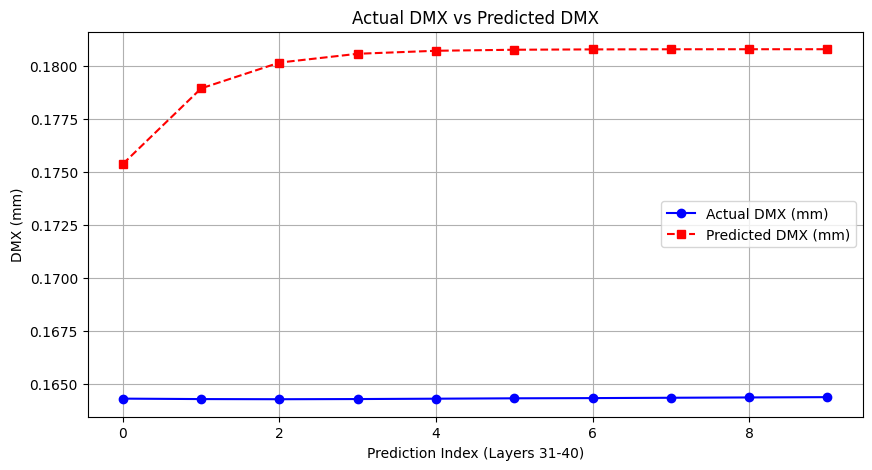

Mean Absolute Error (MAE): 0.01566
Root Mean Squared Error (RMSE): 0.01574


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load Actual Values (Already Uploaded in Colab)
actual_file_path = "/content/FYP_Data_Cuboid.xlsx"
actual_data = pd.read_excel(actual_file_path)

# Load Predicted Values (Ensure you upload this too)
predicted_file_path = "/content/predicted_data_final_fixed.xlsx"
predicted_data = pd.read_excel(predicted_file_path)

# Extract Relevant Columns for Comparison (Rows 31-40)
actual_dmx = actual_data['DMX (mm)'][30:40].reset_index(drop=True)  # Resets the index to align the rows in case plotting misalign values
predicted_dmx = predicted_data['DMX (mm)'][30:40].reset_index(drop=True)

# Compute Error Metrics
mae = mean_absolute_error(actual_dmx, predicted_dmx)
mse = mean_squared_error(actual_dmx, predicted_dmx)
rmse = np.sqrt(mse)

# Visualization of Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(actual_dmx, label="Actual DMX (mm)", marker='o', linestyle='-', color='blue')
plt.plot(predicted_dmx, label="Predicted DMX (mm)", marker='s', linestyle='--', color='red')
plt.xlabel("Prediction Index (Layers 31-40)")
plt.ylabel("DMX (mm)")
plt.title(f"Actual DMX vs Predicted DMX")
plt.legend()
plt.grid(True)
plt.show()

# Display Metrics for the Audience
print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")


 MAE = The average difference between predicted and actual values.

 RMSE = Similar to MAE, but larger errors have a bigger impact, contributing to the RMSE error itself.

 The smaller they are, the better the model is predicting. Aim is to focus on improving the RNN model until the predictions are similar to the actual values.